In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [5]:
from src.pytorch_base.helper import set_seed, plot_loss_accuracy, get_device
from src.pytorch_base.preprocessing import data_augmentations
from src.pytorch_base.dataloader import get_data_loader
from src.paper_nets.resnet import ResNetX
from src.pytorch_base.trainer import (
    train_module,
    test_module,
    model_drivers,
    suggested_lr,
    get_lr_scheduler,
    eval_module,
)
from src.pytorch_base.utils import gardcam_imageprep, grad_cam_trainer
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchinfo import summary
from torchview import draw_graph
import torchvision
from src.pytorch_base.utils import imshow
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns

In [4]:
# Setting up basic training elements
set_seed(71)
device = get_device()
print(device)
batch_size = 512
epochs = 25
learning_rate = 0.5e-3

Random seed set as 71
cuda


## DataPrep

In [5]:
# Specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(classes)

In [6]:
# get CIFAR10 data from torchvision
# downloading train and test data
train = datasets.CIFAR10("./data", train=True, download=True)
test = datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# get dataloader for data batching
dataloader_args = (
    dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    if device.type == "cuda"
    else dict(shuffle=True, batch_size=batch_size)
)

# get train and test transformations
train_transforms, test_transforms = data_augmentations()

# batch loading
train_dataset, train_loader, test_dataset, test_loader = get_data_loader(
    train, test, train_transforms, test_transforms, dataloader_args
)

In [8]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    print(images.mean())
    print(images.std())
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 3, 32, 32])
torch.Size([512])
tensor(0.0391)
tensor(0.9388)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


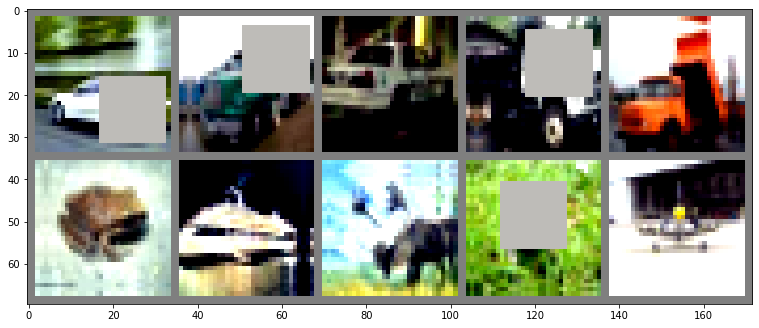

In [9]:
plt.figure(figsize=(13, 11))
imshow(torchvision.utils.make_grid(images[:10], nrow=5))

## Paper Resnet Model

In [10]:
model_parameters = {}
model_parameters["resnet18"] = ([64, 128, 256, 512], [2, 2, 2, 2], 1, False)
model_parameters["resnet34"] = ([64, 128, 256, 512], [3, 4, 6, 3], 1, False)
model_parameters["resnet50"] = ([64, 128, 256, 512], [3, 4, 6, 3], 4, True)
model_parameters["resnet101"] = ([64, 128, 256, 512], [3, 4, 23, 3], 4, True)
model_parameters["resnet152"] = ([64, 128, 256, 512], [3, 8, 36, 3], 4, True)

### Resnet-34

In [11]:
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)
print(resnet_model)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [12]:
summary(resnet_model, (1,3, 32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─ResnetPrepBlock: 1-1                   [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─ResnetBasicBlock: 2-5             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│

In [13]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_34.pt",
)

In [14]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )


    early_stopping(
        test_losses[-1], resnet_model, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


training:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/98 [00:00<?, ?it/s]

Avg Train Loss: 1.6726491694547692 Avg Train Metric: 0.31701853187108525: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.49it/s]


Validation loss decreased (inf --> 1.437146).  Saving model ...
Epoch 1


Avg Train Loss: 1.3258677915650972 Avg Train Metric: 0.5064808194126401: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.94it/s]


Validation loss decreased (1.437146 --> 1.337051).  Saving model ...
Epoch 2


Avg Train Loss: 1.1723211322511946 Avg Train Metric: 0.5705912204421296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


Validation loss decreased (1.337051 --> 1.048370).  Saving model ...
Epoch 3


Avg Train Loss: 1.0741665533610754 Avg Train Metric: 0.6126374328623012: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.34it/s]


Validation loss decreased (1.048370 --> 1.010817).  Saving model ...
Epoch 4


Avg Train Loss: 1.0110260102213646 Avg Train Metric: 0.6380281393625298: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.32it/s]


Validation loss decreased (1.010817 --> 0.951879).  Saving model ...
Epoch 5


Avg Train Loss: 0.9524955068315778 Avg Train Metric: 0.6569561045996997: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.27it/s]


Validation loss decreased (0.951879 --> 0.927768).  Saving model ...
Epoch 6


Avg Train Loss: 0.9145947037910929 Avg Train Metric: 0.6693950721195766: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.25it/s]


Validation loss decreased (0.927768 --> 0.830961).  Saving model ...
Epoch 7


Avg Train Loss: 0.8795090561010399 Avg Train Metric: 0.6898252976183988: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.27it/s]


Validation loss decreased (0.830961 --> 0.791470).  Saving model ...
Epoch 8


Avg Train Loss: 0.8383335641452244 Avg Train Metric: 0.7086055424748635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.34it/s]


EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.8136028422384846 Avg Train Metric: 0.7097326425873504: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.28it/s]


Validation loss decreased (0.791470 --> 0.724564).  Saving model ...
Epoch 10


Avg Train Loss: 0.7860347573854485 Avg Train Metric: 0.7171744527865429: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.27it/s]


EarlyStopping counter: 1 out of 5
Epoch 11


Avg Train Loss: 0.7626595217354444 Avg Train Metric: 0.7333857331957135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.31it/s]


Validation loss decreased (0.724564 --> 0.710429).  Saving model ...
Epoch 12


Avg Train Loss: 0.7331009349044488 Avg Train Metric: 0.7424215406787639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


Validation loss decreased (0.710429 --> 0.687526).  Saving model ...
Epoch 13


Avg Train Loss: 0.7168437212097402 Avg Train Metric: 0.7434307075276667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.22it/s]


Validation loss decreased (0.687526 --> 0.671958).  Saving model ...
Epoch 14


Avg Train Loss: 0.6914110098566327 Avg Train Metric: 0.7582625357472167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.26it/s]


EarlyStopping counter: 1 out of 5
Epoch 15


Avg Train Loss: 0.6880493912161613 Avg Train Metric: 0.7581287750176021: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.30it/s]


Validation loss decreased (0.671958 --> 0.657678).  Saving model ...
Epoch 16


Avg Train Loss: 0.6600466127298317 Avg Train Metric: 0.7679189407095617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.649294880579929 Avg Train Metric: 0.7705560083291969: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.24it/s]


EarlyStopping counter: 2 out of 5
Epoch 18


Avg Train Loss: 0.6347901577852211 Avg Train Metric: 0.7779398846382998: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.33it/s]


Validation loss decreased (0.657678 --> 0.626378).  Saving model ...
Epoch 19


Avg Train Loss: 0.6201746141423985 Avg Train Metric: 0.7793785978336724: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.22it/s]


EarlyStopping counter: 1 out of 5
Epoch 20


Avg Train Loss: 0.6130516304045307 Avg Train Metric: 0.782254518294821: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


Validation loss decreased (0.626378 --> 0.610306).  Saving model ...
Epoch 21


Avg Train Loss: 0.5843305864504406 Avg Train Metric: 0.7990551481441576: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.28it/s]


EarlyStopping counter: 1 out of 5
Epoch 22


Avg Train Loss: 0.5850539903859703 Avg Train Metric: 0.7948770218965958: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.35it/s]


EarlyStopping counter: 2 out of 5
Epoch 23


Avg Train Loss: 0.5741793385573796 Avg Train Metric: 0.8008746766314214: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.18it/s]


Validation loss decreased (0.610306 --> 0.605417).  Saving model ...
Epoch 24


Avg Train Loss: 0.565950618410597 Avg Train Metric: 0.8074660386357989: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


Validation loss decreased (0.605417 --> 0.565712).  Saving model ...


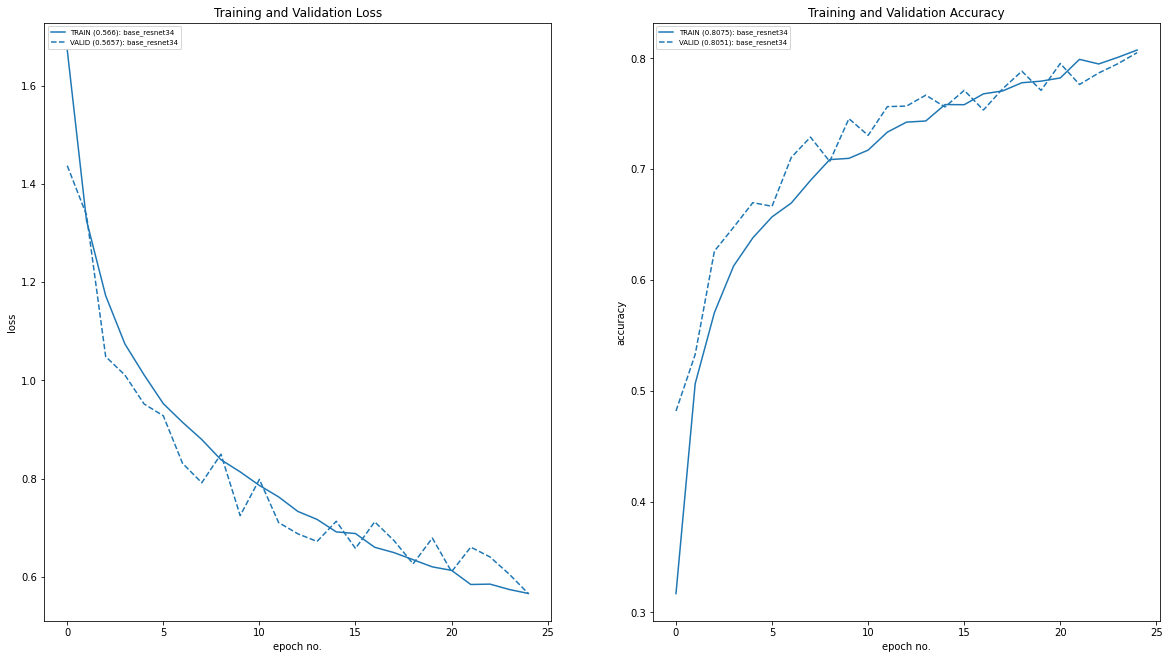

In [15]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet34"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

### Resnet-18

In [16]:
resnet_model_2 = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)
print(resnet_model_2)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [17]:
summary(resnet_model_2, (1,3, 32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─ResnetPrepBlock: 1-1                   [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─ResnetBasicBlock: 2-5             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│

In [18]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model_2,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_18.pt",
)

In [19]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model_2,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model_2,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )


    early_stopping(
        test_losses[-1], resnet_model_2, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


Avg Train Loss: 1.7833742726416815 Avg Train Metric: 0.2798816221100943:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 41/98 [00:03<00:04, 12.79it/s]

Avg Train Loss: 1.5877653141410983 Avg Train Metric: 0.34410063405426183: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.11it/s]


Validation loss decreased (inf --> 1.345110).  Saving model ...
Epoch 1


Avg Train Loss: 1.2626520456099997 Avg Train Metric: 0.5341591336289231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Validation loss decreased (1.345110 --> 1.081565).  Saving model ...
Epoch 2


Avg Train Loss: 1.1197684741750056 Avg Train Metric: 0.5877677475919529: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.05it/s]


Validation loss decreased (1.081565 --> 0.997816).  Saving model ...
Epoch 3


Avg Train Loss: 1.0298077488432125 Avg Train Metric: 0.6301914009512687: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]


Validation loss decreased (0.997816 --> 0.950054).  Saving model ...
Epoch 4


Avg Train Loss: 0.9695869635562507 Avg Train Metric: 0.6525929941206562: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]


Validation loss decreased (0.950054 --> 0.853047).  Saving model ...
Epoch 5


Avg Train Loss: 0.9175442262571685 Avg Train Metric: 0.6737906786860252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]


Validation loss decreased (0.853047 --> 0.819364).  Saving model ...
Epoch 6


Avg Train Loss: 0.8731660319834339 Avg Train Metric: 0.6862300342443038: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


EarlyStopping counter: 1 out of 5
Epoch 7


Avg Train Loss: 0.8416780908497012 Avg Train Metric: 0.7033463923298583: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]


Validation loss decreased (0.819364 --> 0.766890).  Saving model ...
Epoch 8


Avg Train Loss: 0.8034624980420483 Avg Train Metric: 0.7147855831652271: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.17it/s]


Validation loss decreased (0.766890 --> 0.762879).  Saving model ...
Epoch 9


Avg Train Loss: 0.7830482690918202 Avg Train Metric: 0.7208433169491437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


Validation loss decreased (0.762879 --> 0.718297).  Saving model ...
Epoch 10


Avg Train Loss: 0.7590791297202207 Avg Train Metric: 0.7284451583210303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


EarlyStopping counter: 1 out of 5
Epoch 11


Avg Train Loss: 0.7311088017054966 Avg Train Metric: 0.7395497974084349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.22it/s]


Validation loss decreased (0.718297 --> 0.698100).  Saving model ...
Epoch 12


Avg Train Loss: 0.7095220709333614 Avg Train Metric: 0.7523004065970985: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


Validation loss decreased (0.698100 --> 0.660520).  Saving model ...
Epoch 13


Avg Train Loss: 0.6905839686491051 Avg Train Metric: 0.7587331588170967: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.12it/s]


EarlyStopping counter: 1 out of 5
Epoch 14


Avg Train Loss: 0.669470379547197 Avg Train Metric: 0.7685822631631579: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]


EarlyStopping counter: 2 out of 5
Epoch 15


Avg Train Loss: 0.6541406913679473 Avg Train Metric: 0.7689896304996646: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]


Validation loss decreased (0.660520 --> 0.622417).  Saving model ...
Epoch 16


Avg Train Loss: 0.6348423446927752 Avg Train Metric: 0.7813887614376691: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.23it/s]


EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.6222842737120025 Avg Train Metric: 0.7850233273846763: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]


EarlyStopping counter: 2 out of 5
Epoch 18


Avg Train Loss: 0.6054720142666175 Avg Train Metric: 0.7878141013943419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]


EarlyStopping counter: 3 out of 5
Epoch 19


Avg Train Loss: 0.5927845461636173 Avg Train Metric: 0.7903647374133674: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.11it/s]


Validation loss decreased (0.622417 --> 0.613542).  Saving model ...
Epoch 20


Avg Train Loss: 0.5802881672066085 Avg Train Metric: 0.7978094366131997: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.12it/s]


Validation loss decreased (0.613542 --> 0.593131).  Saving model ...
Epoch 21


Avg Train Loss: 0.5685597177670927 Avg Train Metric: 0.8015444984241408: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


EarlyStopping counter: 1 out of 5
Epoch 22


Avg Train Loss: 0.5533550466809954 Avg Train Metric: 0.8050228904704658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.14it/s]


EarlyStopping counter: 2 out of 5
Epoch 23


Avg Train Loss: 0.5397208241783843 Avg Train Metric: 0.8087754632745471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.17it/s]


EarlyStopping counter: 3 out of 5
Epoch 24


Avg Train Loss: 0.5309952570467579 Avg Train Metric: 0.8146815318234113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.13it/s]


EarlyStopping counter: 4 out of 5


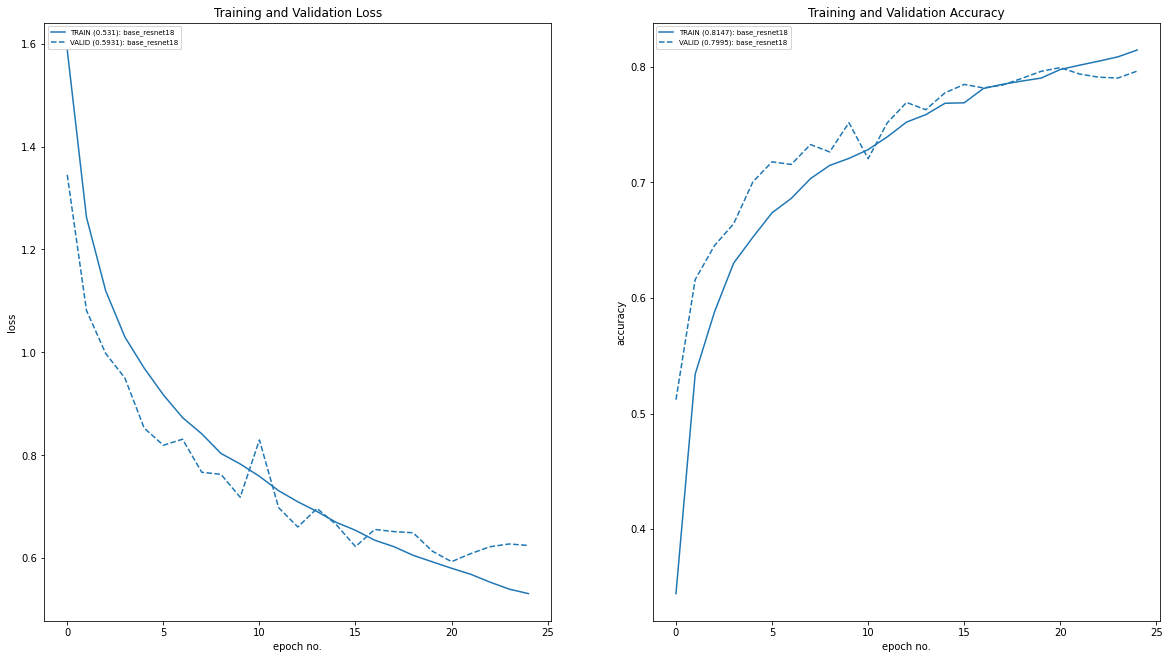

In [20]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet18"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

As we see we are stuck with a constant learning rate , we would like to switch to different optimizer like SGD and also application of One cycle policy and try with RESENT18

In [21]:
resnet_model_new = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)
print(resnet_model_new)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [22]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model_new,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_18_schd.pt",
)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.36E-03


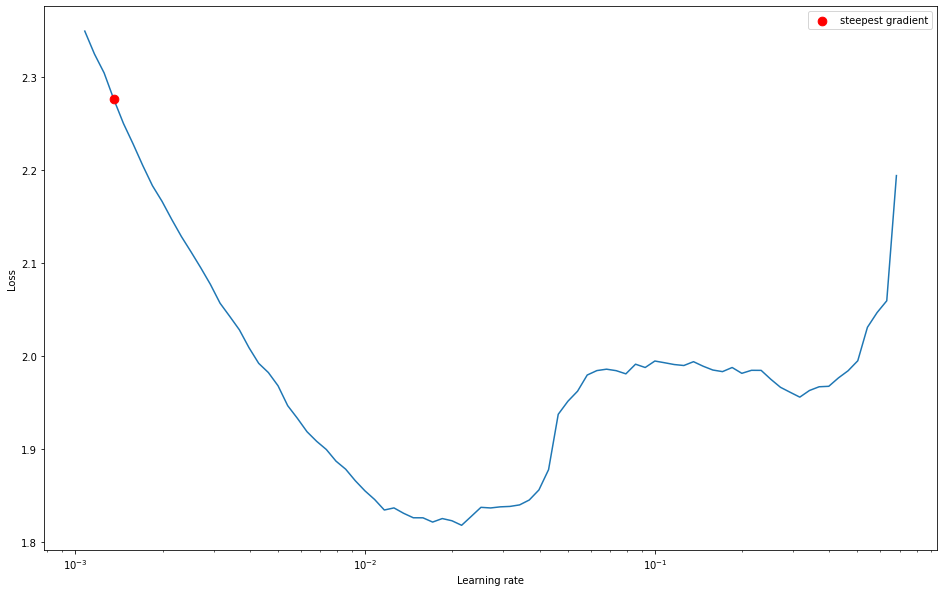

In [23]:
suggested_lr(resnet_model_new, optimizer, criterion, device, 1, 100, train_loader)

In [30]:
suggested_lr = 1.36E-02
print(suggested_lr)

0.0136


Application of One Cycle LR

In [31]:
resnet_model_new = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)
print(resnet_model_new)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [32]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model_new,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_18_schd.pt",
)

In [33]:
scheduler = get_lr_scheduler(
    type="CyclicLR",
    optimizer=optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=5 / epochs,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

In [34]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model_new,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model_new,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )
    # Lr scheduler added
    scheduler.step()
    print(f"Learning rate ahead: {scheduler.get_last_lr()}")

    early_stopping(
        test_losses[-1], resnet_model_new, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


training:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/98 [00:00<?, ?it/s]

Avg Train Loss: 1.7112368856157576 Avg Train Metric: 0.31457466251996097: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.77it/s]


Learning rate ahead: [0.00016353374233128834]
Validation loss decreased (inf --> 1.391015).  Saving model ...
Epoch 1


Avg Train Loss: 1.4120411897192195 Avg Train Metric: 0.4706994693498222: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.53it/s]


Learning rate ahead: [0.00019106748466257668]
Validation loss decreased (1.391015 --> 1.234373).  Saving model ...
Epoch 2


Avg Train Loss: 1.2881056958315324 Avg Train Metric: 0.52818235998251: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]


Learning rate ahead: [0.00021860122699386502]
Validation loss decreased (1.234373 --> 1.142655).  Saving model ...
Epoch 3


Avg Train Loss: 1.1937581300735474 Avg Train Metric: 0.5623541516917092: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.01it/s]


Learning rate ahead: [0.00024613496932515336]
Validation loss decreased (1.142655 --> 1.034122).  Saving model ...
Epoch 4


Avg Train Loss: 1.1140675933993593 Avg Train Metric: 0.5974043838831843: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


Learning rate ahead: [0.0002736687116564417]
Validation loss decreased (1.034122 --> 0.985062).  Saving model ...
Epoch 5


Avg Train Loss: 1.052790372347345 Avg Train Metric: 0.6188772144366284: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.95it/s]


Learning rate ahead: [0.00030120245398773004]
Validation loss decreased (0.985062 --> 0.933175).  Saving model ...
Epoch 6


Avg Train Loss: 1.000793035541262 Avg Train Metric: 0.6381678581237793: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.06it/s]


Learning rate ahead: [0.0003287361963190184]
Validation loss decreased (0.933175 --> 0.862558).  Saving model ...
Epoch 7


Avg Train Loss: 0.9512308428482134 Avg Train Metric: 0.6600674275232821: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.06it/s]


Learning rate ahead: [0.0003562699386503068]
EarlyStopping counter: 1 out of 5
Epoch 8


Avg Train Loss: 0.9241449395004584 Avg Train Metric: 0.6755332356813003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.12it/s]


Learning rate ahead: [0.00038380368098159506]
Validation loss decreased (0.862558 --> 0.844373).  Saving model ...
Epoch 9


Avg Train Loss: 0.8856773546763829 Avg Train Metric: 0.6880119850440901: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.07it/s]


Learning rate ahead: [0.0004113374233128834]
Validation loss decreased (0.844373 --> 0.832334).  Saving model ...
Epoch 10


Avg Train Loss: 0.8626154363155365 Avg Train Metric: 0.6957493339266095: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.04it/s]


Learning rate ahead: [0.00043887116564417174]
Validation loss decreased (0.832334 --> 0.811374).  Saving model ...
Epoch 11


Avg Train Loss: 0.8335358676861744 Avg Train Metric: 0.7073399357649744: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]


Learning rate ahead: [0.0004664049079754601]
Validation loss decreased (0.811374 --> 0.761366).  Saving model ...
Epoch 12


Avg Train Loss: 0.8081567044160805 Avg Train Metric: 0.7122435831293767: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.04it/s]


Learning rate ahead: [0.0004939386503067484]
Validation loss decreased (0.761366 --> 0.745221).  Saving model ...
Epoch 13


Avg Train Loss: 0.7820426937268705 Avg Train Metric: 0.7221927052857925: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.06it/s]


Learning rate ahead: [0.0005214723926380367]
EarlyStopping counter: 1 out of 5
Epoch 14


Avg Train Loss: 0.7699217394906648 Avg Train Metric: 0.7250292672186481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.12it/s]


Learning rate ahead: [0.0005490061349693251]
Validation loss decreased (0.745221 --> 0.703524).  Saving model ...
Epoch 15


Avg Train Loss: 0.7480946876564805 Avg Train Metric: 0.7362863311962206: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.09it/s]


Learning rate ahead: [0.0005765398773006135]
EarlyStopping counter: 1 out of 5
Epoch 16


Avg Train Loss: 0.732259384223393 Avg Train Metric: 0.7420480458103881: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.01it/s]


Learning rate ahead: [0.0006040736196319019]
EarlyStopping counter: 2 out of 5
Epoch 17


Avg Train Loss: 0.7200496792793274 Avg Train Metric: 0.7475362456574732: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.08it/s]


Learning rate ahead: [0.0006316073619631901]
Validation loss decreased (0.703524 --> 0.685720).  Saving model ...
Epoch 18


Avg Train Loss: 0.6961569524541193 Avg Train Metric: 0.7546813585320298: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.00it/s]


Learning rate ahead: [0.0006591411042944785]
EarlyStopping counter: 1 out of 5
Epoch 19


Avg Train Loss: 0.6828801029798935 Avg Train Metric: 0.7606964749949319: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.02it/s]


Learning rate ahead: [0.0006866748466257669]
Validation loss decreased (0.685720 --> 0.673089).  Saving model ...
Epoch 20


Avg Train Loss: 0.6709919431988074 Avg Train Metric: 0.7676460092165032: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.04it/s]


Learning rate ahead: [0.0007142085889570552]
EarlyStopping counter: 1 out of 5
Epoch 21


Avg Train Loss: 0.6657260072474577 Avg Train Metric: 0.7649420822153286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.94it/s]


Learning rate ahead: [0.0007417423312883434]
Validation loss decreased (0.673089 --> 0.652576).  Saving model ...
Epoch 22


Avg Train Loss: 0.6441717202566108 Avg Train Metric: 0.7733794724454686: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.07it/s]


Learning rate ahead: [0.0007692760736196318]
EarlyStopping counter: 1 out of 5
Epoch 23


Avg Train Loss: 0.6341070654440899 Avg Train Metric: 0.7748229868557989: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.10it/s]


Learning rate ahead: [0.0007968098159509202]
Validation loss decreased (0.652576 --> 0.648274).  Saving model ...
Epoch 24


Avg Train Loss: 0.6243467270111551 Avg Train Metric: 0.7803381419911677: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.97it/s]


Learning rate ahead: [0.0008243435582822086]
EarlyStopping counter: 1 out of 5


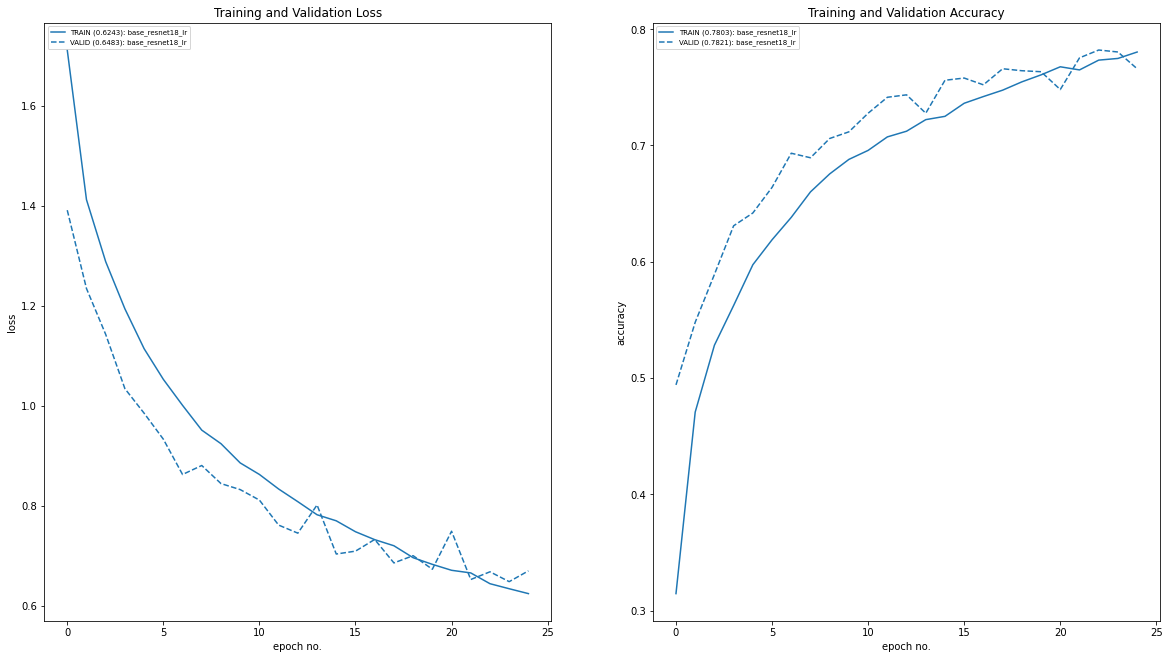

In [35]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet18_lr"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

#### Evaluation and Metrics

In [36]:
# get dataloader for data batching
dataloader_args = dict(
    shuffle=False,
    batch_size=1,
)

# batch loading
_, _, evaldataset, eval_loader = get_data_loader(
    None, test, None, test_transforms, dataloader_args
)

In [37]:
actuals , predictions = eval_module(resnet_model_new, device, eval_loader)

Evaluation:   0%|████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 48/10000 [00:00<01:04, 155.31it/s]

Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 156.39it/s]


In [38]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.85      0.72      0.78      1000
  automobile       0.88      0.85      0.87      1000
        bird       0.74      0.71      0.72      1000
         cat       0.59      0.60      0.59      1000
        deer       0.82      0.70      0.75      1000
         dog       0.69      0.71      0.70      1000
        frog       0.79      0.86      0.82      1000
       horse       0.83      0.80      0.81      1000
        ship       0.85      0.90      0.88      1000
       truck       0.72      0.91      0.80      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



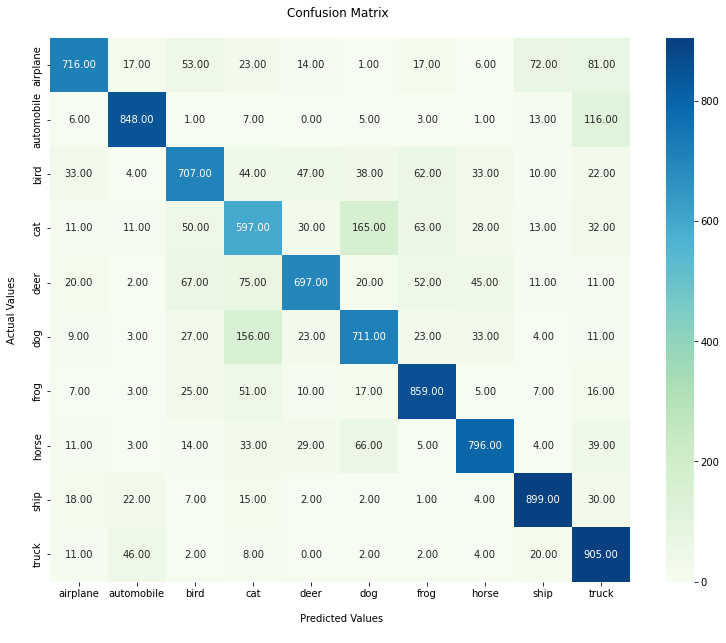

In [39]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [40]:
mismatches_idx = np.where(predictions != actuals)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


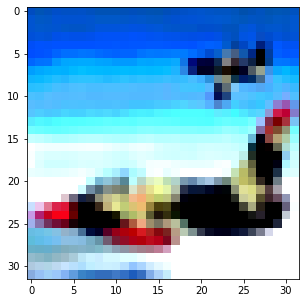

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane and Prediction: ship


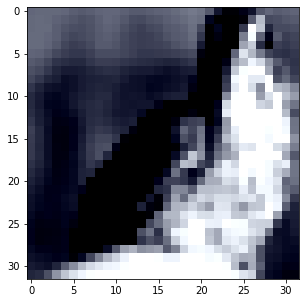

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird and Prediction: cat


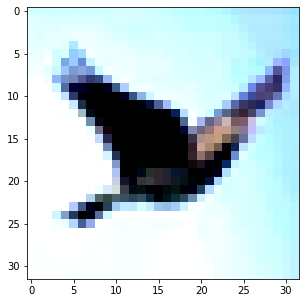

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird and Prediction: airplane


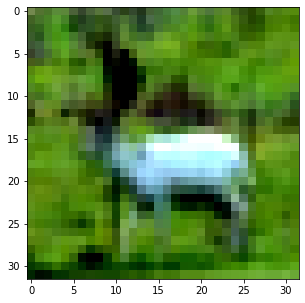

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: deer and Prediction: horse


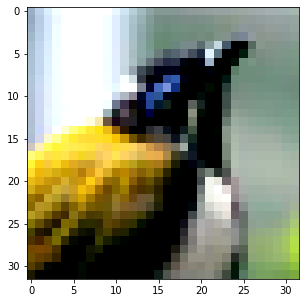

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird and Prediction: deer


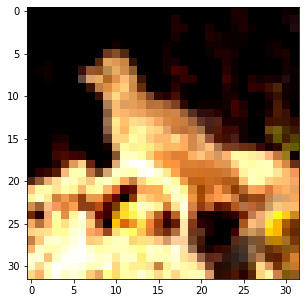

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird and Prediction: frog


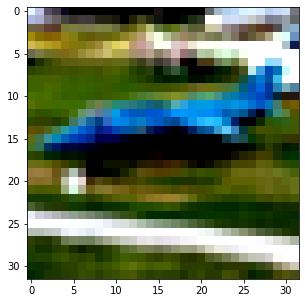

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane and Prediction: automobile


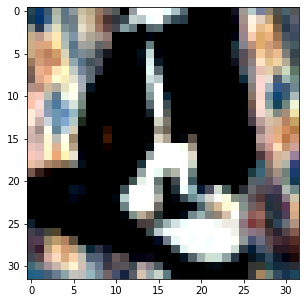

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog and Prediction: truck


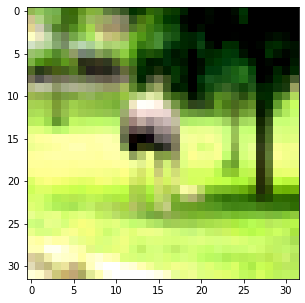

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird and Prediction: deer


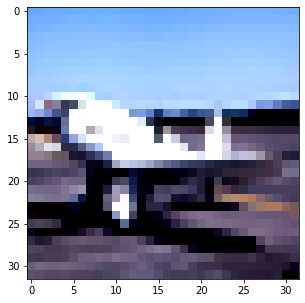

Label: airplane and Prediction: truck


In [45]:
sample_miss_idx = []
for idx in mismatches_idx[0][-10:]:
    sample_miss_idx.append(idx)
    plt.figure(figsize=(5, 5))
    img, label = evaldataset[idx]
    imshow(img)
    print(f"Label: {classes[label]} and Prediction: {classes[predictions[idx]]}")
    plt.show()

#### Application of Gradcam - ExplainableAI

Extracting last layer of the model and passing the misclassified labels of a few images to the gradcam trainer

In [46]:
# taking whole of layer3 of the model
target_layers = [resnet_model_new.layer3]

Label: airplane and Prediction: ship


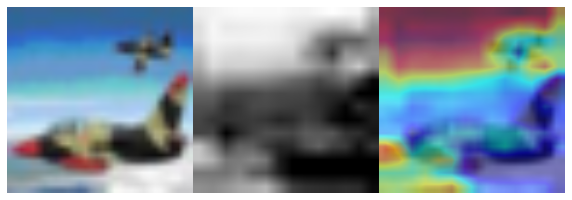




Label: bird and Prediction: cat


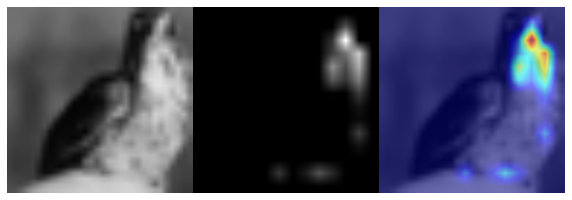




Label: bird and Prediction: airplane


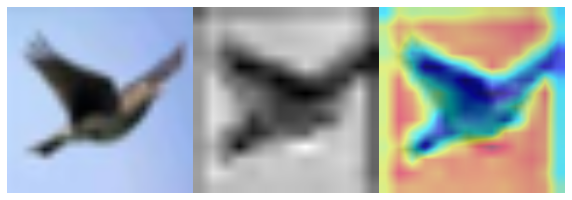




Label: deer and Prediction: horse


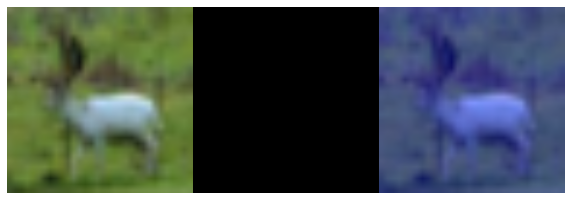




Label: bird and Prediction: deer


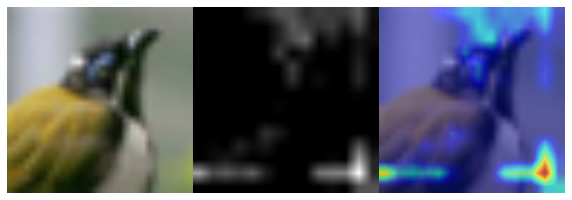




Label: bird and Prediction: frog


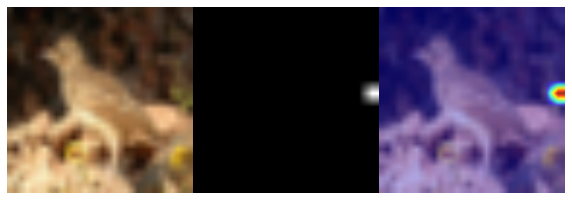




Label: airplane and Prediction: automobile


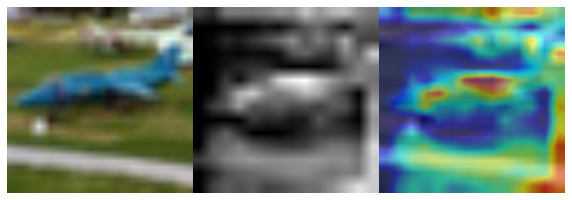




Label: dog and Prediction: truck


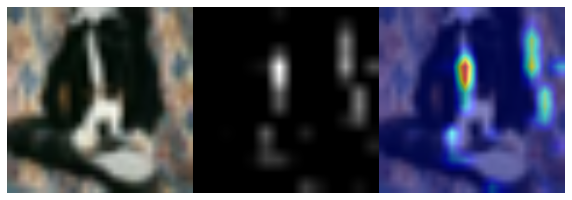




Label: bird and Prediction: deer


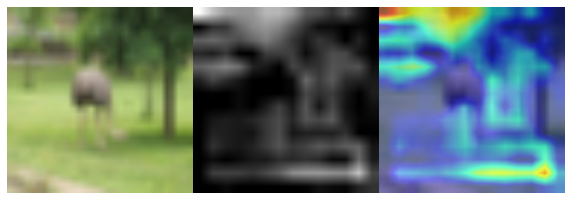




Label: airplane and Prediction: truck


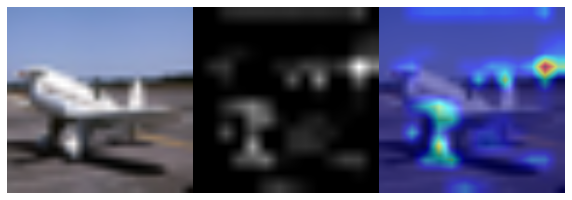

In [49]:
for idx, (image, label) in enumerate(test):
    if idx in sample_miss_idx:
        img, input_tensor = gardcam_imageprep(image)
        prediction_label = predictions[idx]
        op = grad_cam_trainer(
            resnet_model_new, target_layers, img, input_tensor, prediction_label
        )
        print(f"Label: {classes[label]} and Prediction: {classes[prediction_label]}")
        plt.figure(figsize=(10, 9))
        plt.imshow(op)
        plt.axis('off')
        plt.show()
        plt.close()
        print("\n\n")